In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

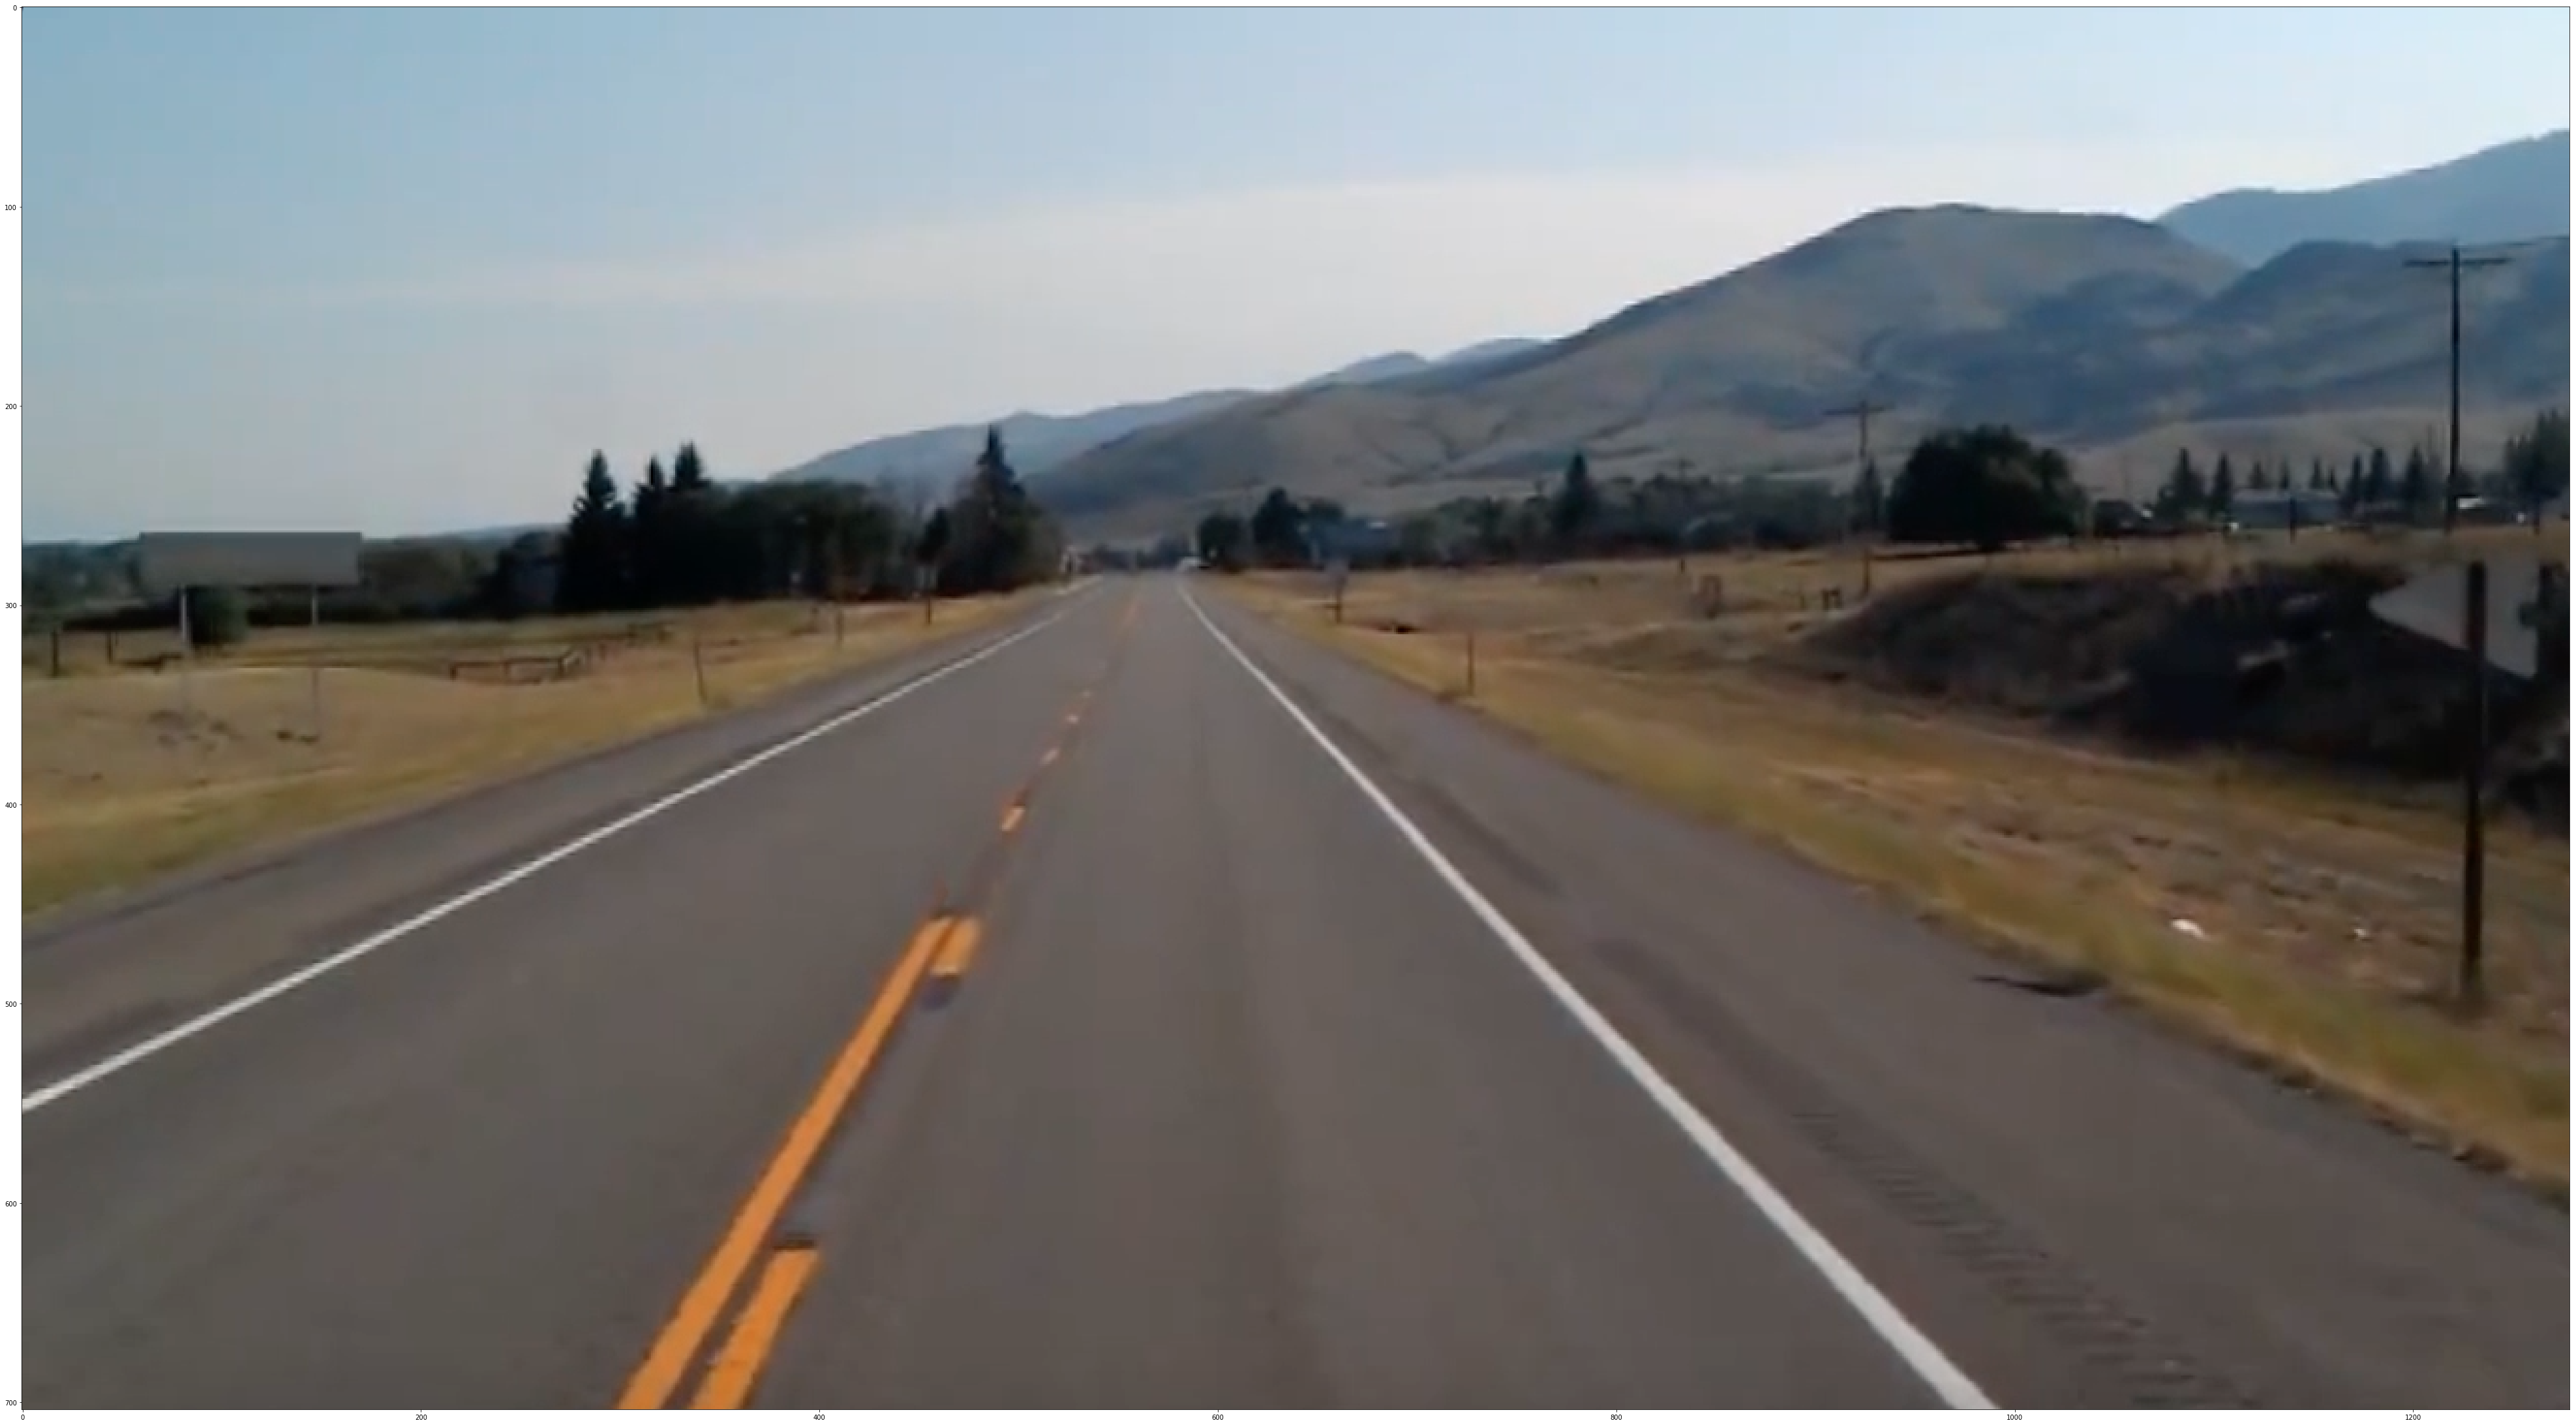

In [4]:
image = cv2.imread('test_image.jpg')
w,h = len(image)//10,len(image[0])//10
plt.figure(figsize = (w,h))
plt.imshow(image[:,:,::-1]) # bgr--rgb

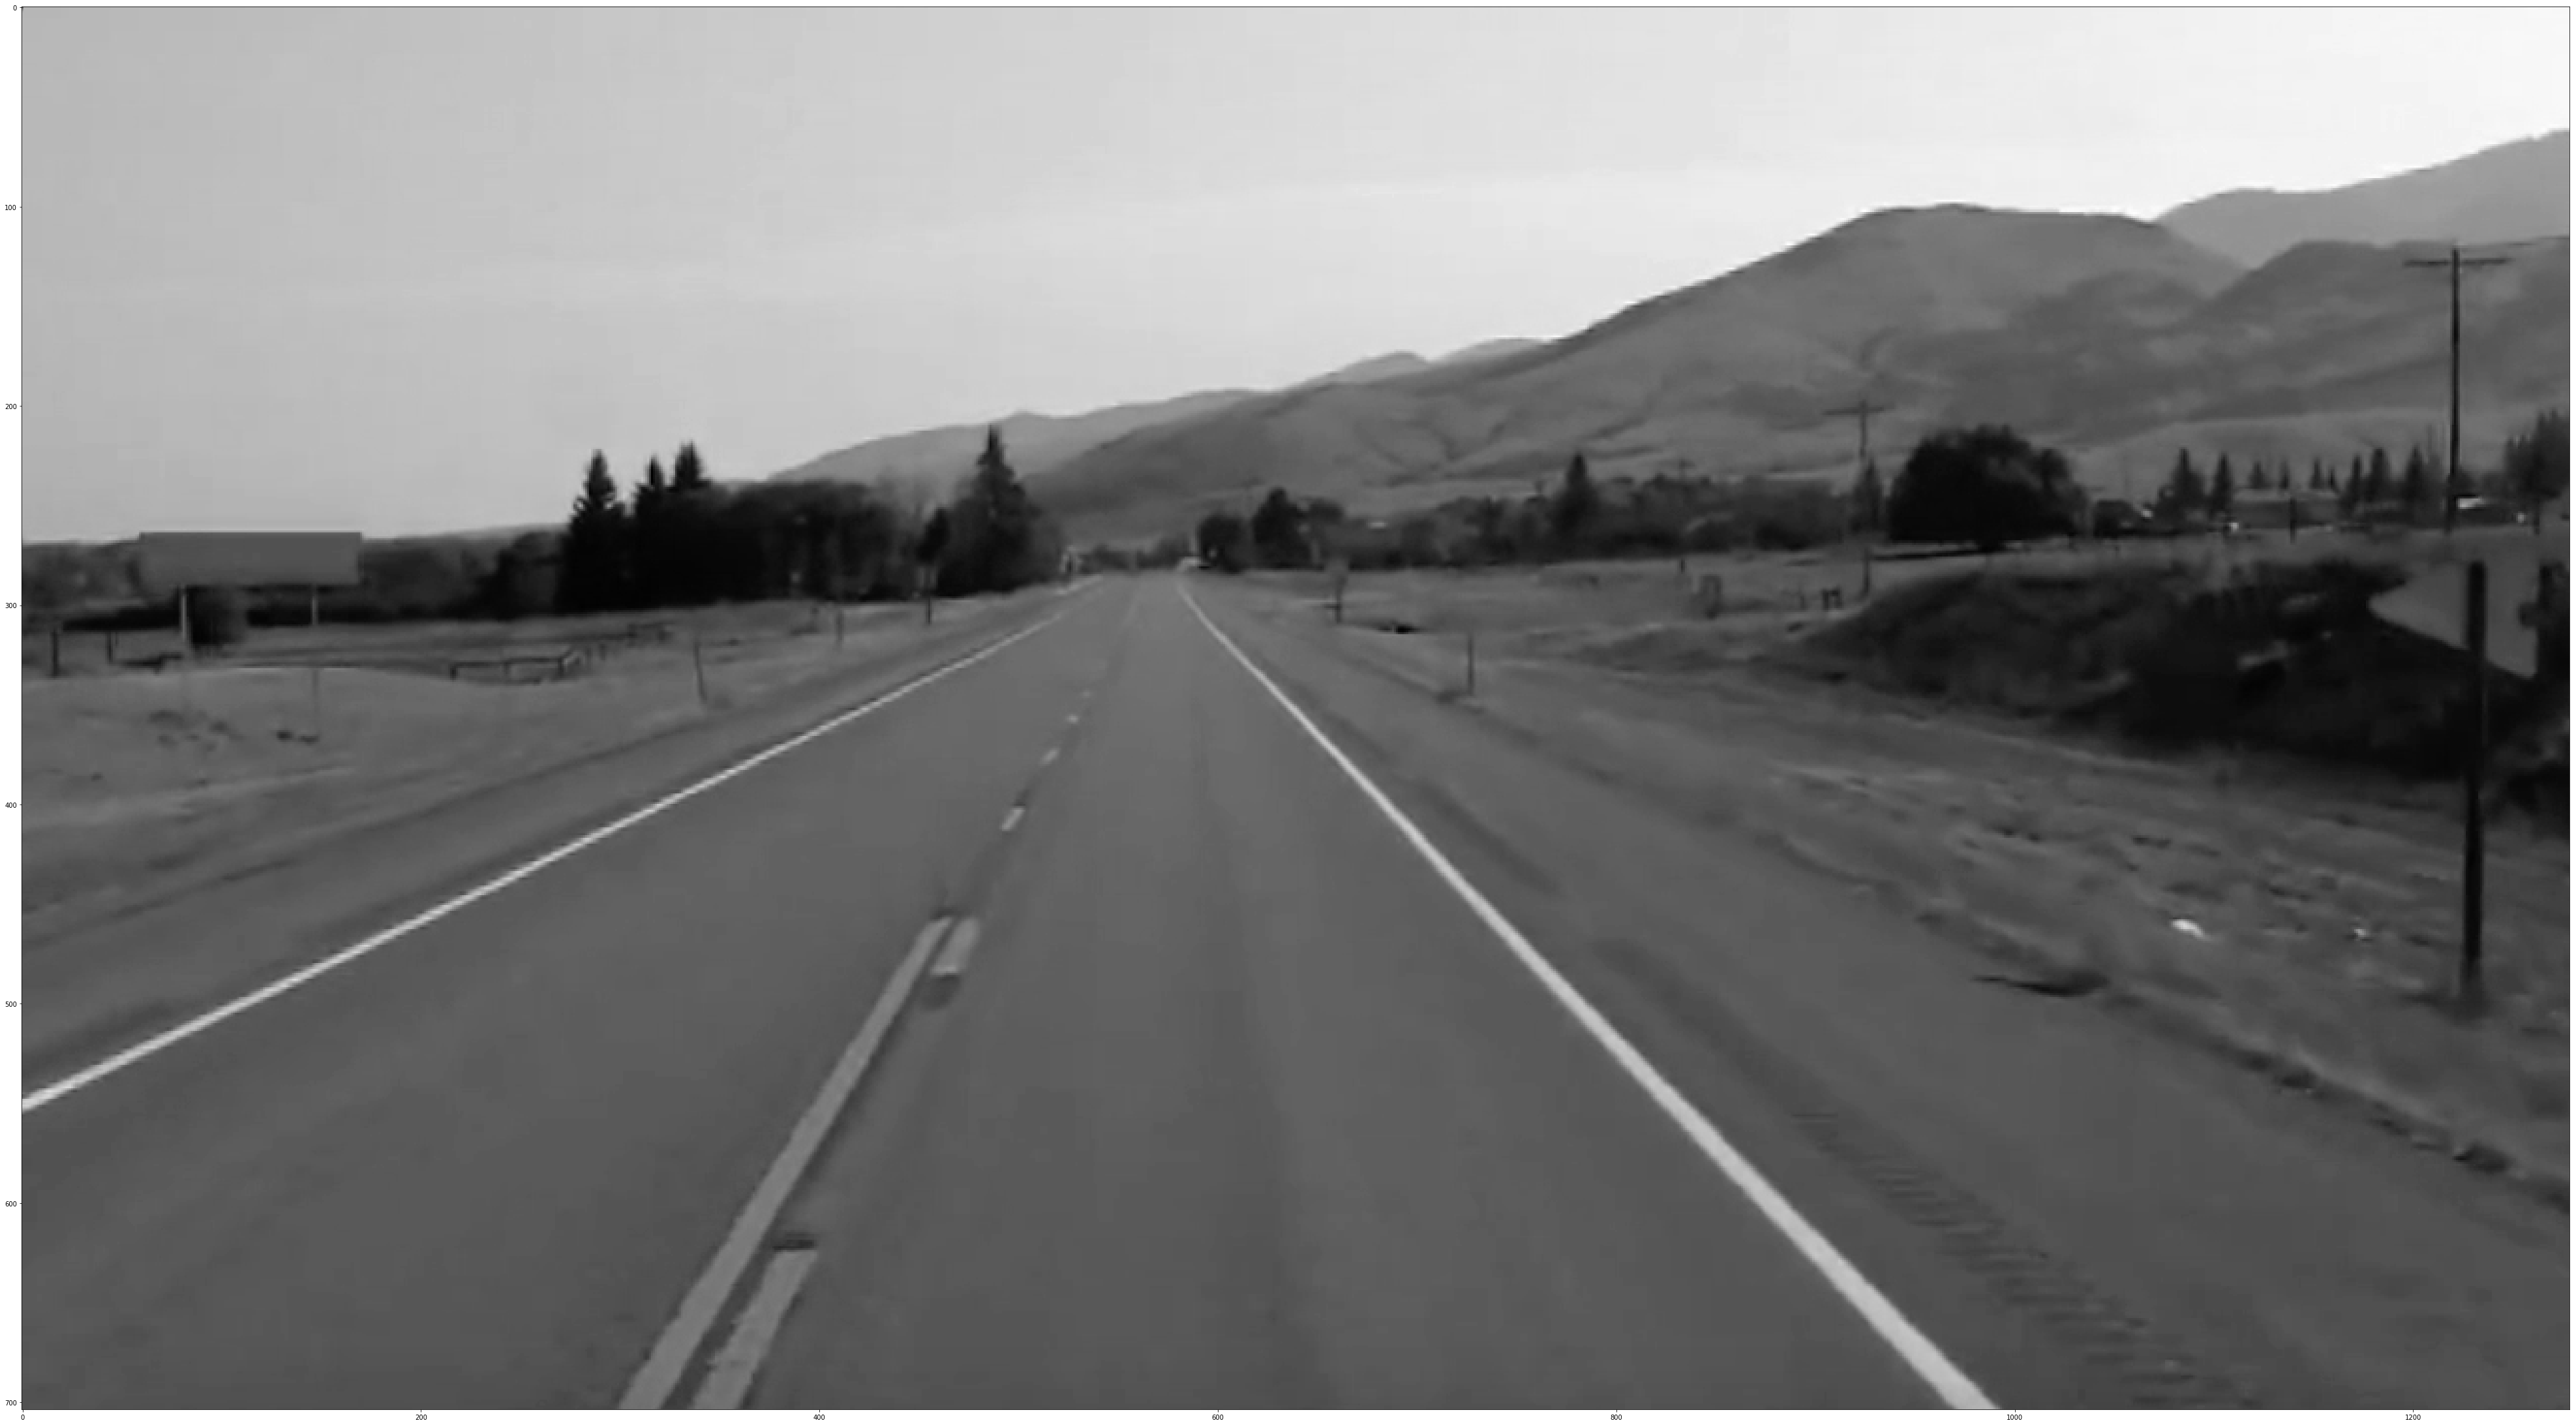

In [5]:
'''convert rgb to grey'''
lane_image = np.copy(image)
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
plt.figure(figsize = (w,h))
plt.imshow(gray,'gray')

In [6]:
'''apply guasion blur to reduce noise caused edges'''
blur = cv2.GaussianBlur(gray, (5,5), 0)

plt.figure(figsize = (w,h))
plt.imshow(blur,'gray')

In [7]:
'''apply canny function to find edges'''
canny = cv2.Canny(blur,50,150) # 50,150 corresponding to the low and high threshhold

plt.figure(figsize = (w,h))
plt.imshow(canny,'gray')

In [8]:
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur,50,150)
    return canny

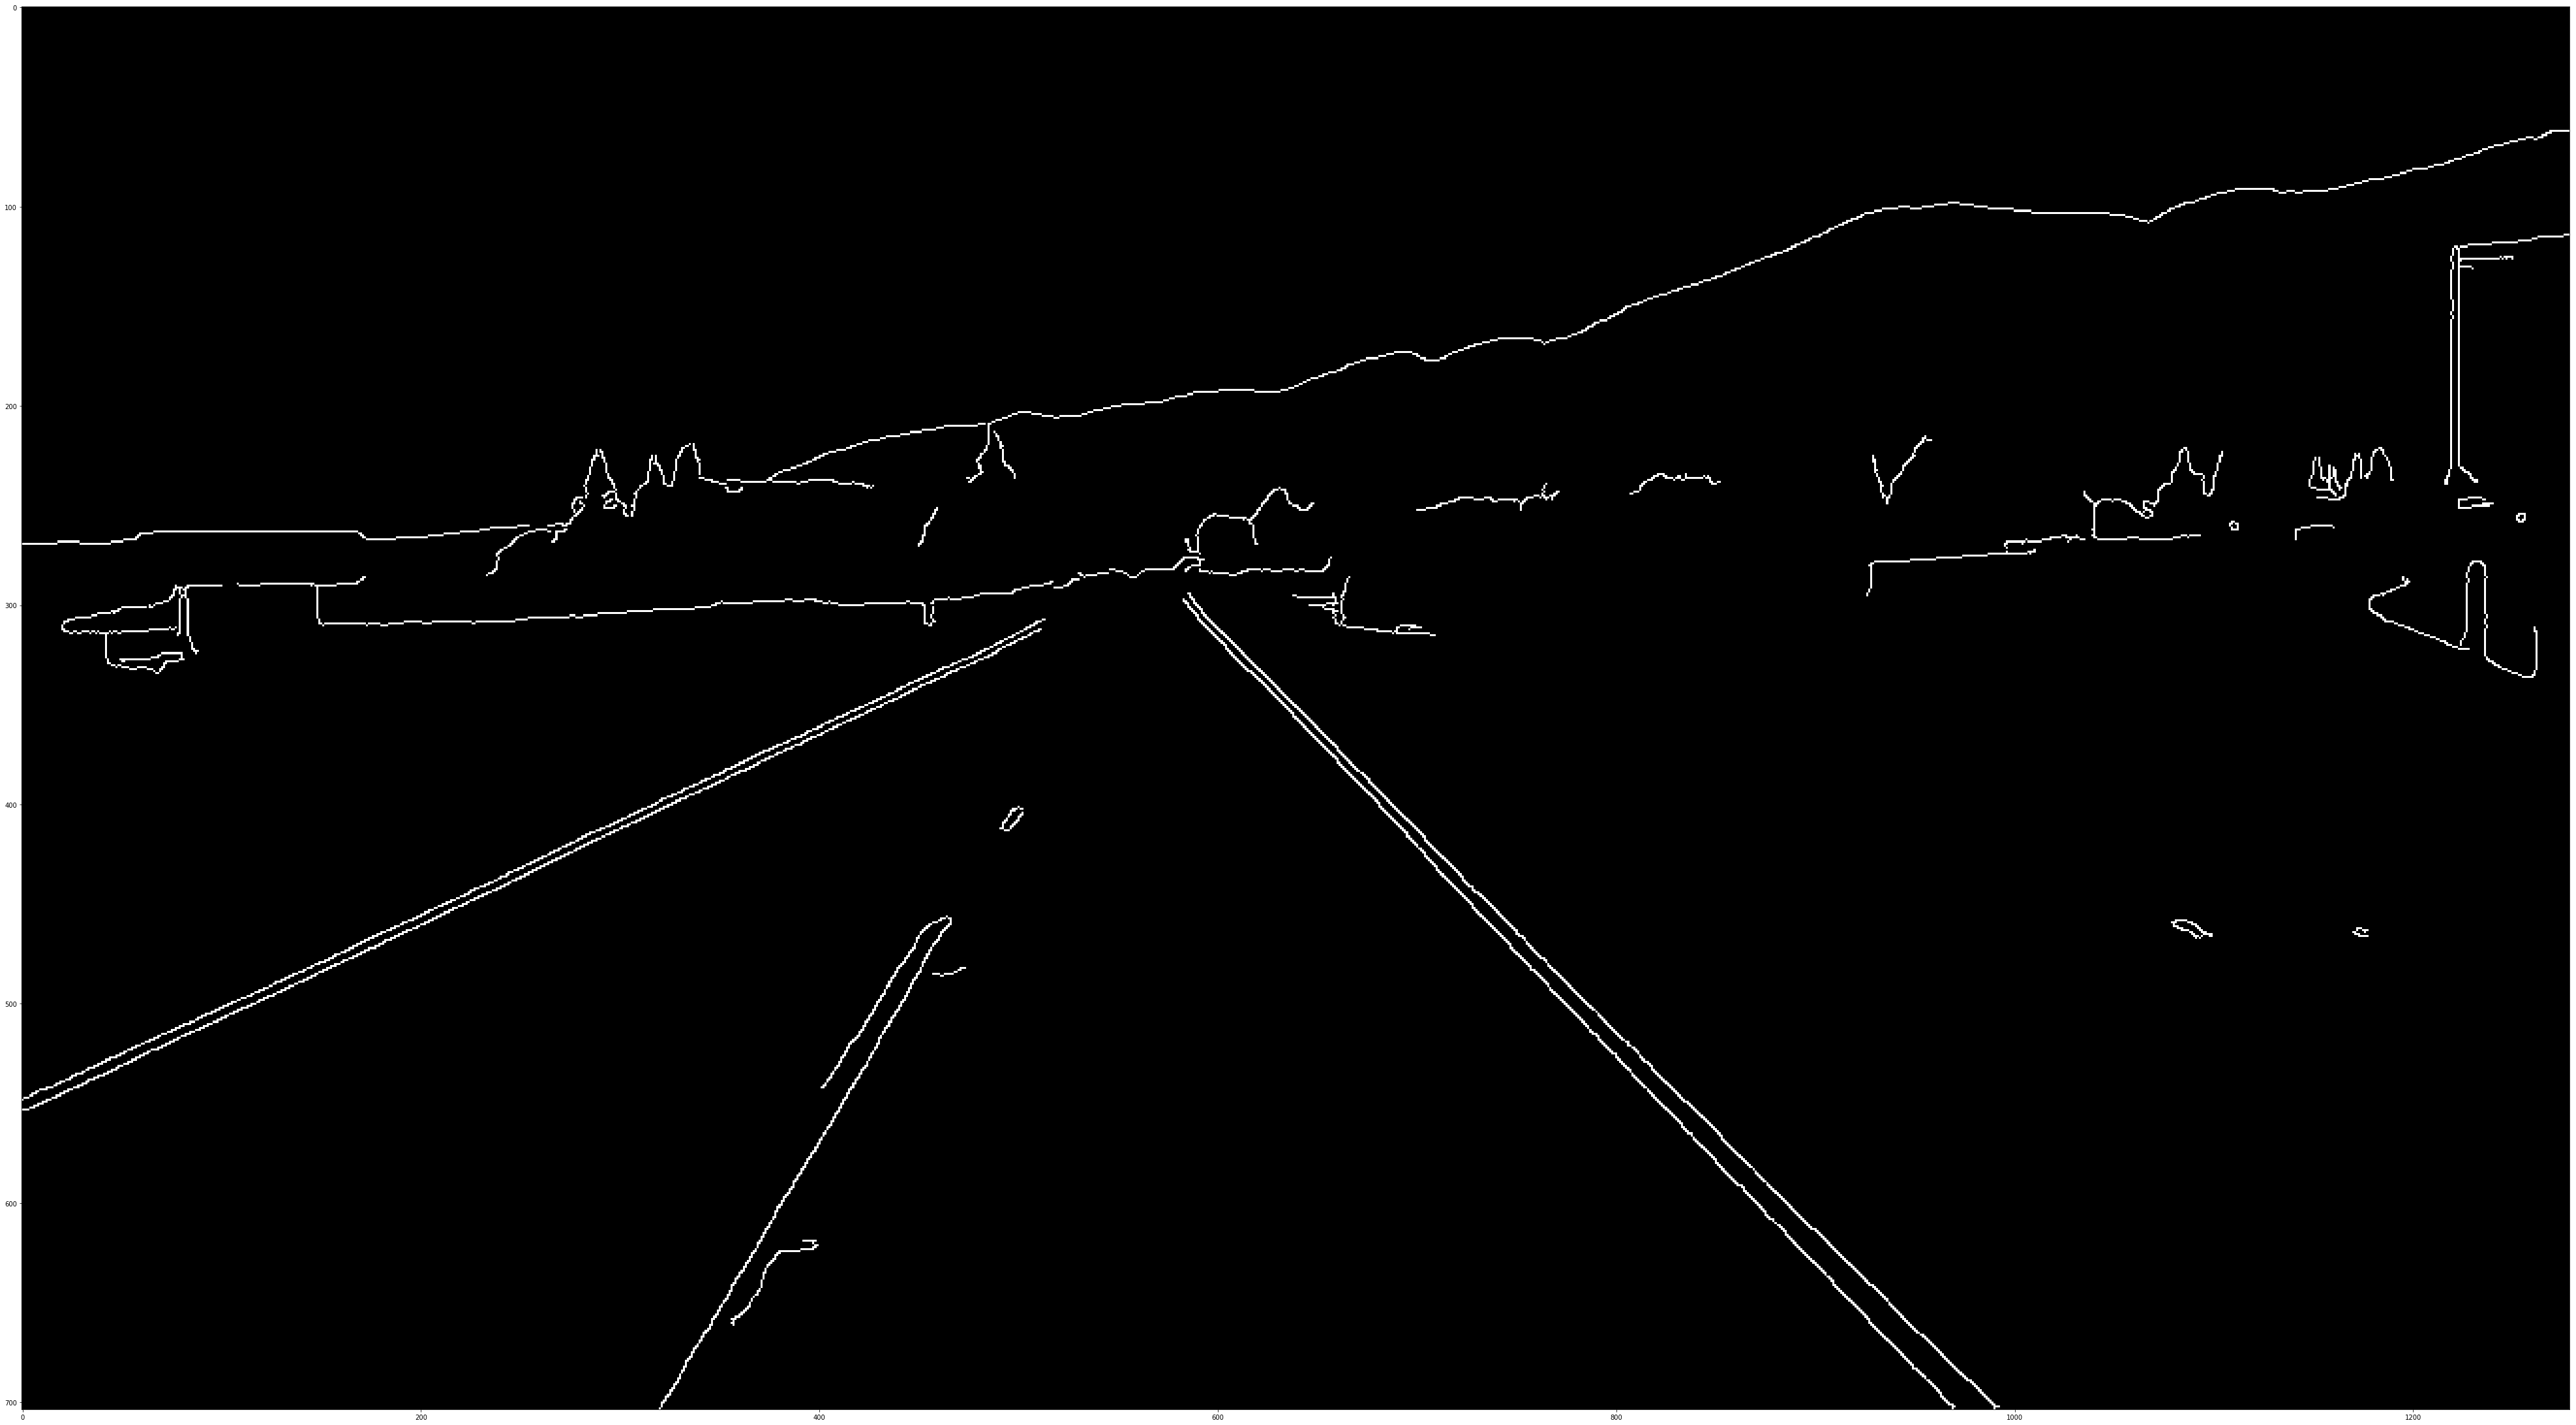

In [9]:
canny_image = canny(lane_image)
plt.figure(figsize = (w,h))
plt.imshow(canny_image,'gray')

In [10]:
'''def the area of interest'''
def region_of_interest(image):
    height=image.shape[0]
    triangle = np.array([[(200,height),(1100,height),(550,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,triangle,255) # fill the ploygons in a list with 255 
    '''crop the fig by applying bitwise & operation between the image and mask'''
    masked_image = cv2.bitwise_and(image,mask) # image&mask works as well
    return masked_image

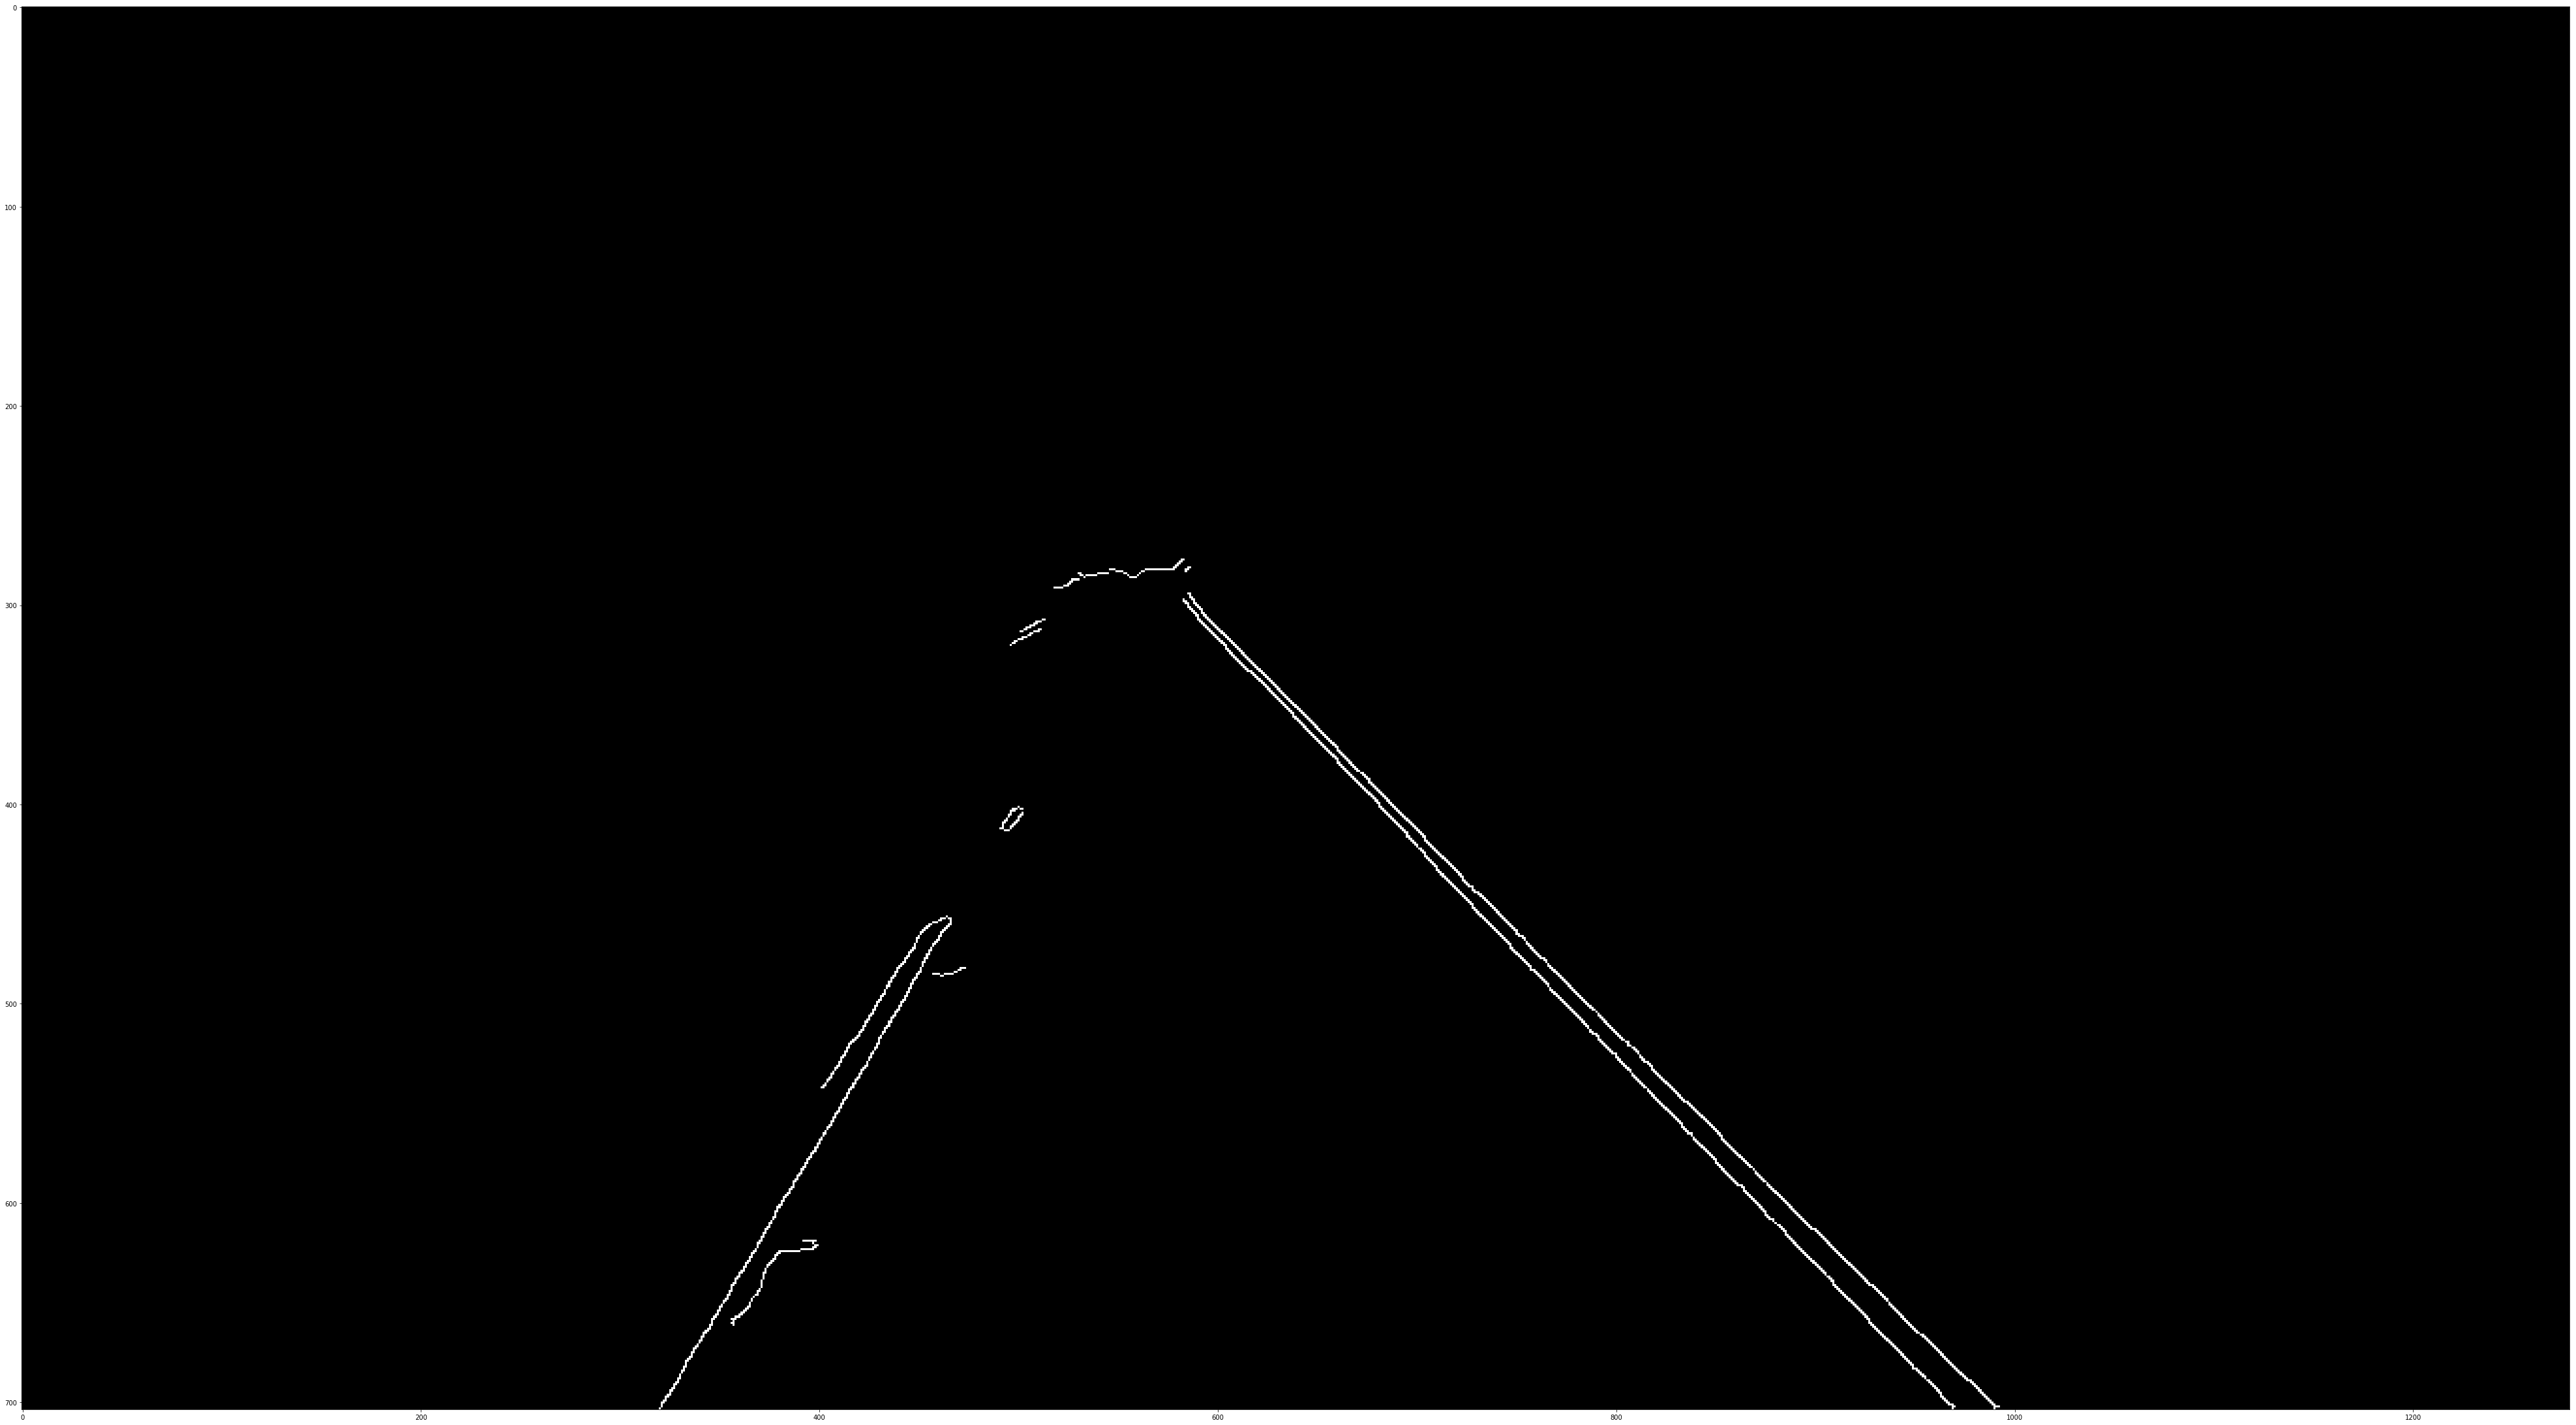

In [12]:
masked_image = region_of_interest(canny_image)
plt.figure(figsize = (w,h))
plt.imshow(masked_image,'gray')

In [18]:
'''
Hough transformation
args: image, resolution=2pixel, pi/180, threshhold of the intersections need,minLineLength,maxLineGap
'''
lines = cv2.HoughLinesP(masked_image,2,np.pi/180,100,np.array([]),minLineLength=20, maxLineGap=5) 

In [19]:
print(lines)

[[[704 418 927 641]]

 [[704 426 791 516]]

 [[320 703 445 494]]

 [[585 301 663 381]]

 [[630 341 670 383]]

 [[669 387 704 424]]

 [[787 513 807 533]]

 [[787 514 969 702]]

 [[659 371 704 416]]

 [[592 304 643 355]]

 [[423 509 454 461]]

 [[859 574 887 602]]]


In [20]:
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10) #bgr color,width
    return line_image
            
       

In [21]:
line_image = display_lines(lane_image,lines)
plt.figure(figsize = (w,h))
plt.imshow(line_image[:,:,::-1])     

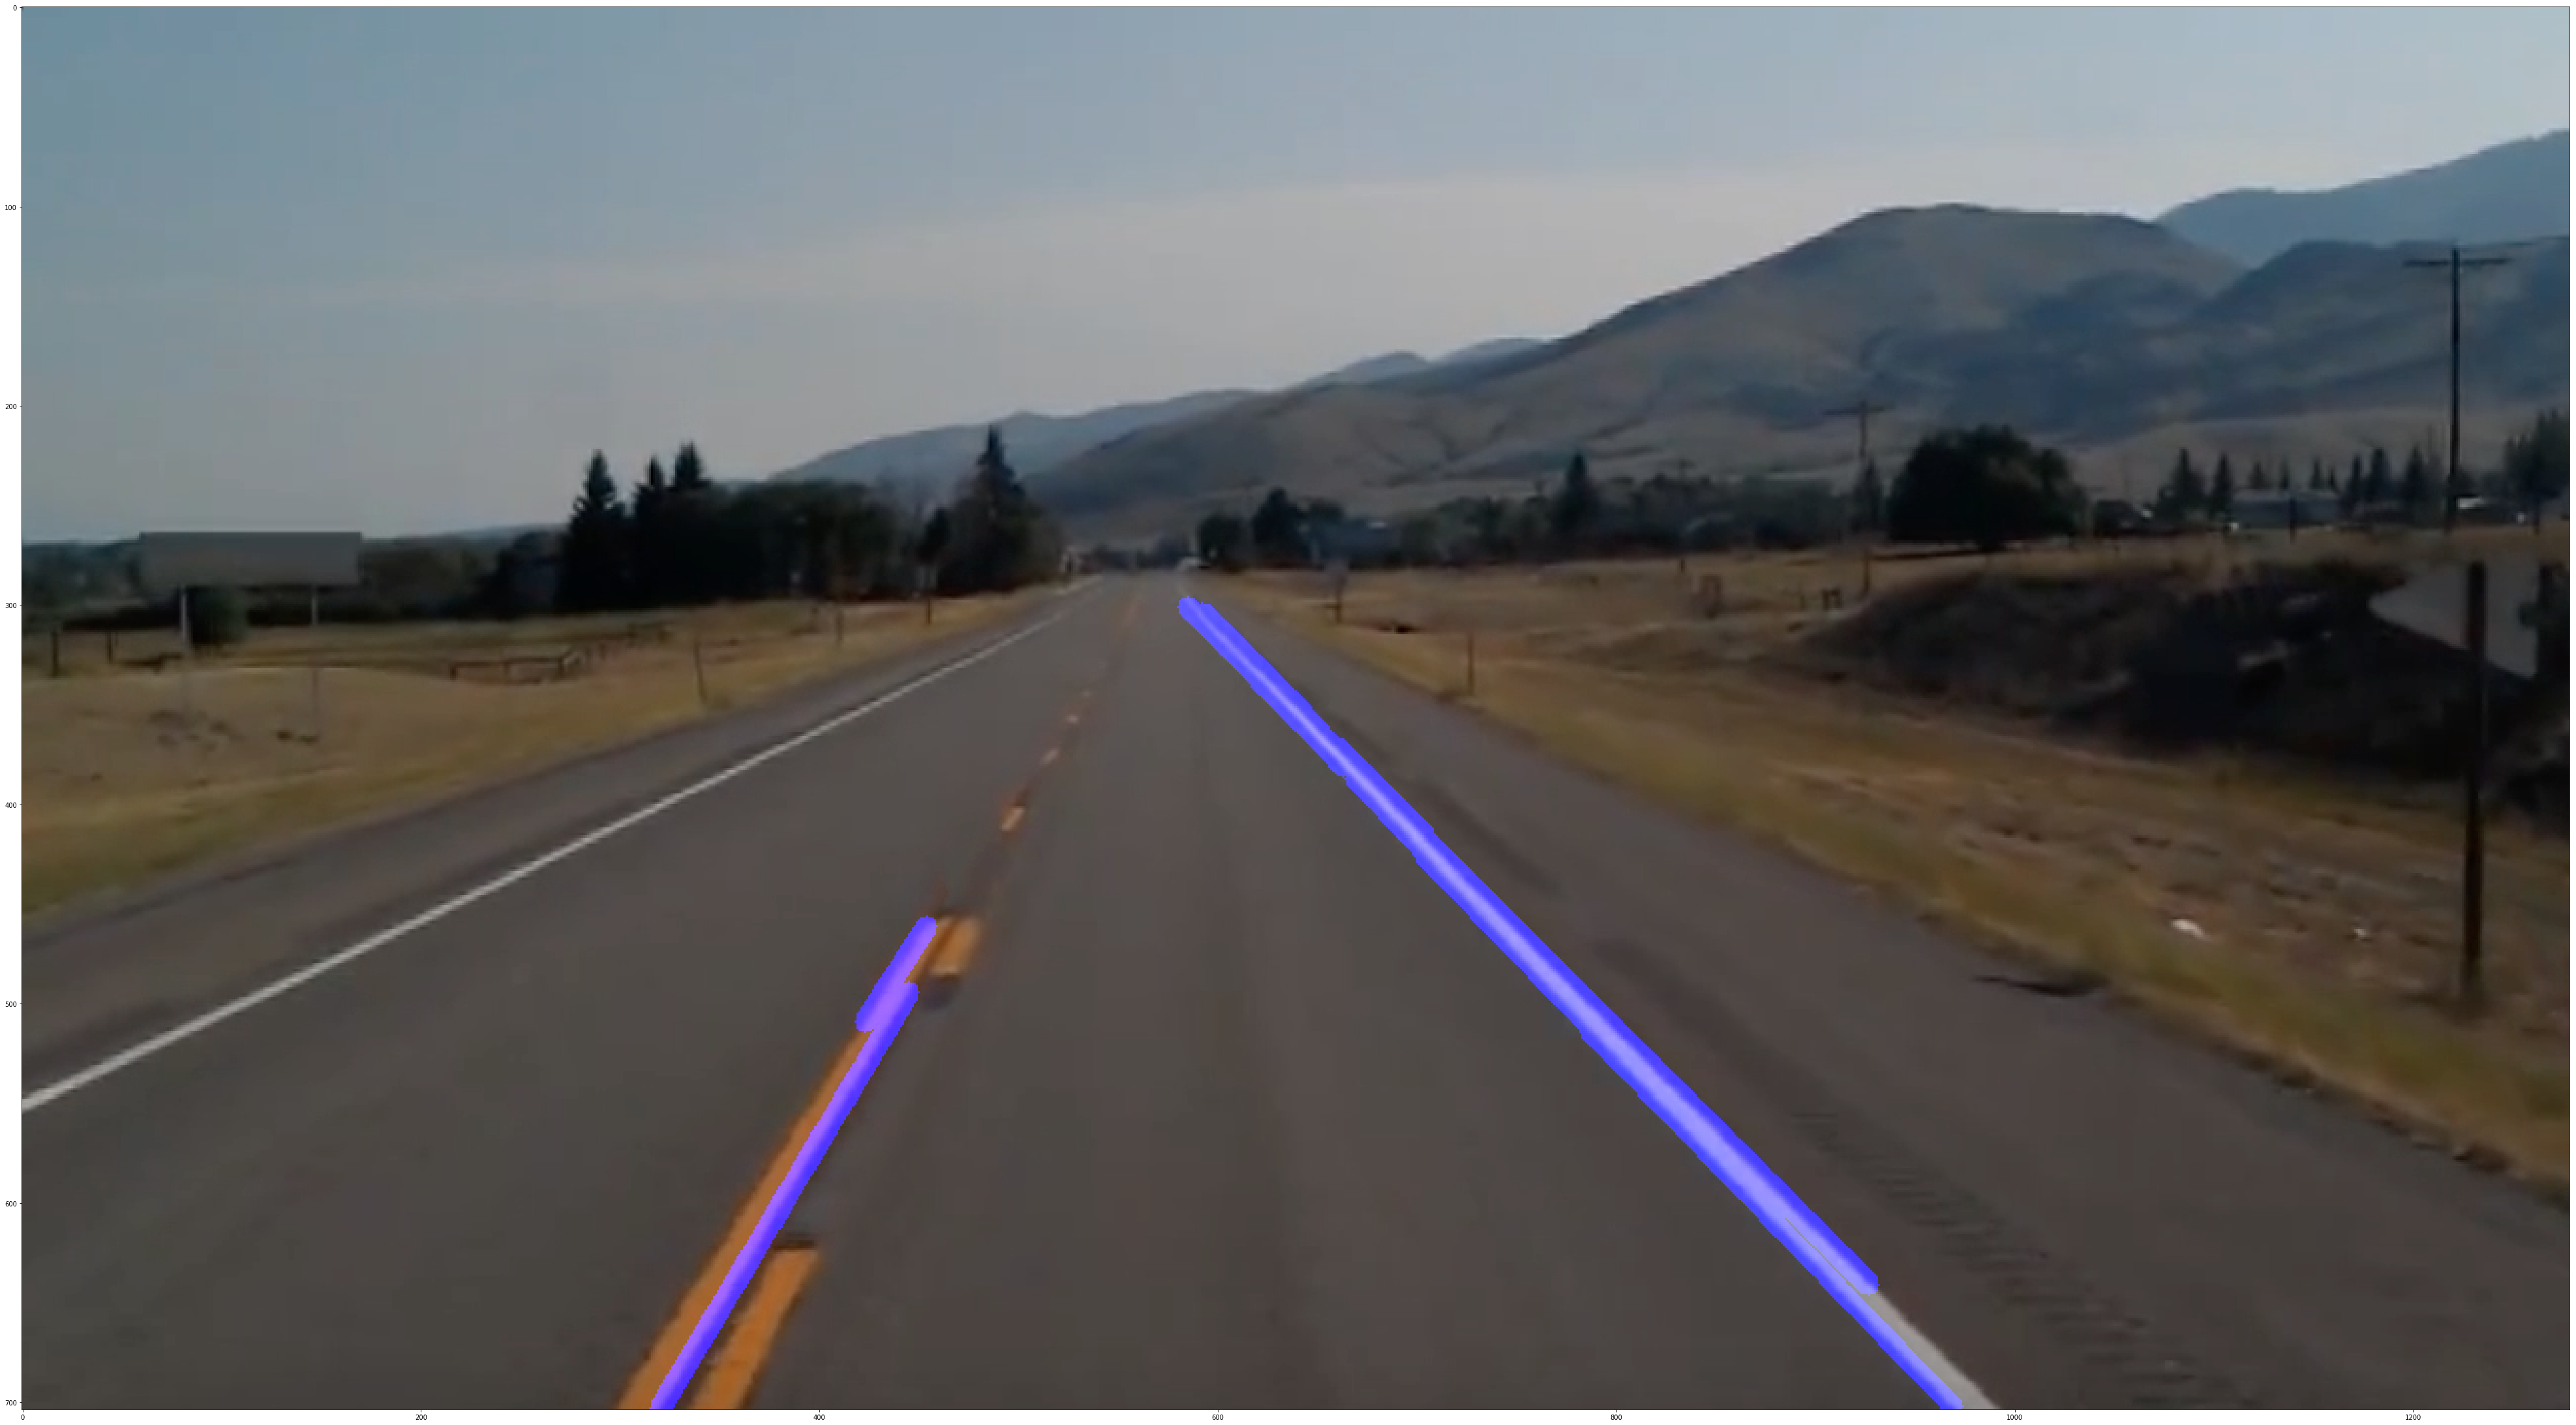

In [22]:
'''overlay the image'''
combo_image = cv2.addWeighted(lane_image,0.8,line_image,1,gamma=1)

plt.figure(figsize = (w,h))
plt.imshow(combo_image[:,:,::-1])     

In [25]:
def make_coordinates(image,line_parameters):
    try:
        slope,intercept = line_parameters
        
        y1 = image.shape[0]
        y2 = int(y1*3/5)
        x1 = int((y1-intercept)/slope)
        x2 = int((y2-intercept)/slope)
    except:
        y1 = 0
        y2 = 0
        x1 = 0
        x2 = 0
    return np.array([x1,y1,x2,y2])

In [26]:
'''average the lines to two lines: left and right'''
def average_slope_intercept(image,lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        slope,intercept = np.polyfit ((x1,x2),(y1,y2),1)
        if slope < 0 :
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    left_fit_average = np.average(left_fit,axis=0)
    right_fit_average = np.average(right_fit,axis=0)
    left_line = make_coordinates(image,left_fit_average)
    right_line = make_coordinates(image,right_fit_average)
    return np.array([left_line,right_line])
    
    
    

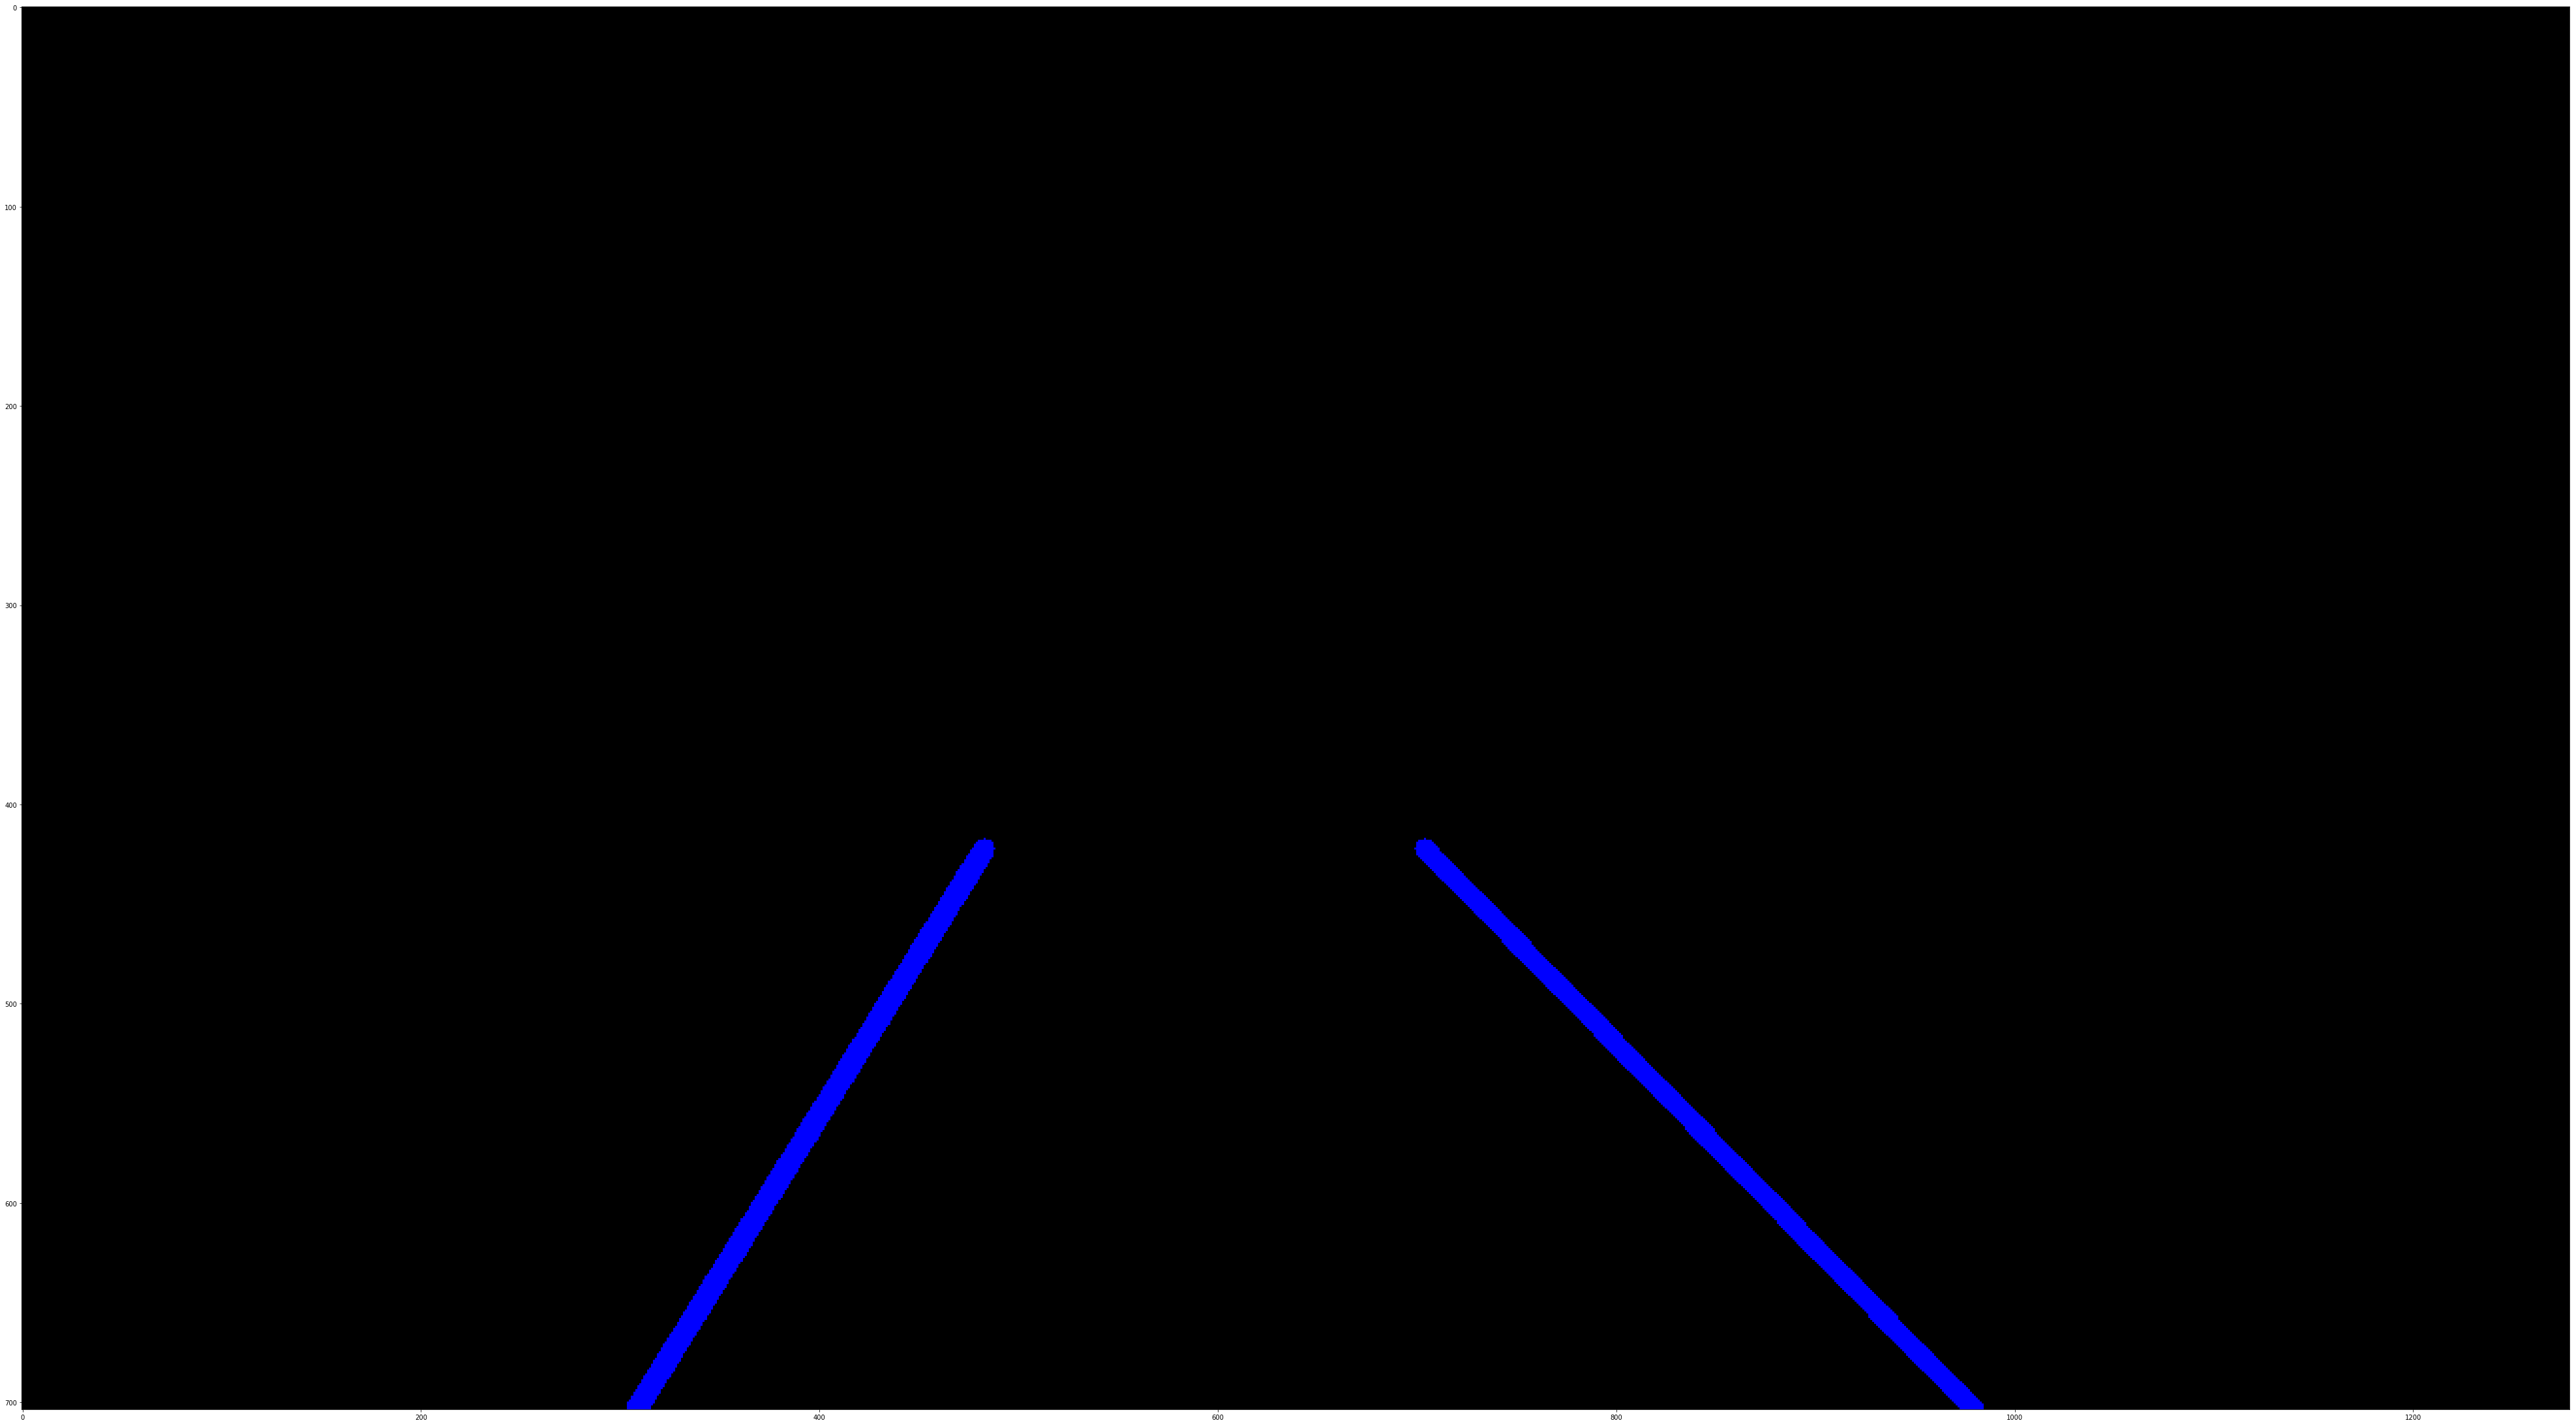

In [27]:
average_lines = average_slope_intercept(lane_image,lines)

average_line_image = display_lines(lane_image,average_lines)
plt.figure(figsize = (w,h))
plt.imshow(average_line_image[:,:,::-1])     

In [28]:
combo_average_image = cv2.addWeighted(lane_image,0.8,average_line_image,1,gamma=1)

plt.figure(figsize = (w,h))
plt.imshow(combo_average_image[:,:,::-1])     

In [30]:
cv2.imshow('result',combo_average_image)  #the fiorst arg is the name of the window
cv2.waitKey(0)

-1

In [56]:
'''apply this to a video frame by frame'''

cap = cv2.VideoCapture('test2.mp4')

# Define the codec and create VideoWriter object.The output is stored in 'test2out.avi' file.
# Define the fps to be equal to 30. Also frame size is passed.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('test2out.mp4',0x7634706d, 50, (frame_width,frame_height))

        
while(cap.isOpened()):
    _, frame = cap.read()
    
    '''copy the above code here'''
    canny_image = canny(frame)
    masked_image = region_of_interest(canny_image)
    lines = cv2.HoughLinesP(masked_image,2,np.pi/180,100,np.array([]),minLineLength=40, maxLineGap=5)
    average_lines = average_slope_intercept(frame,lines)
    average_line_image = display_lines(frame,average_lines)
    combo_average_image = cv2.addWeighted(frame,0.8,average_line_image,1,gamma=1)
    cv2.imshow('result',combo_average_image)
    out.write(combo_average_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
out.release()
cv2.destroyAllWindows()
    
    